This notebook was created by Donna Faith Go.

In [1]:
# import sys
# !{sys.executable} -m pip install arch

In [2]:
# standard imports
import matplotlib.pyplot as plt
import pandas as pd 
import pickle
import numpy as np
import seaborn as sns
from typing import Tuple

# data gathering
import yfinance as yf

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# GARCH model
from arch import arch_model

# topological data analysis
from ripser import Rips
import persim
from persim.landscapes import PersLandscapeExact, PersLandscapeApprox
from persim.landscapes import plot_landscape_simple

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# GARCH on the PSEi

This notebook aims to do volatility clustering on the Philippine Stock Exchange Composite Index (PSEi) through the Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model.

## Data Gathering

In [3]:
# getting closing prices for the 30 stocks with batching
start_date = '2013-01-01'# '2019-01-01'
end_date = '2026-01-01' #'2025-08-01'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     ['PSEI.PS'], 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('psei closing prices.pkl')

In [4]:
filepath = r'psei closing prices.pkl'
with open(filepath, 'rb') as f:
    pse_data = pickle.load(f)

# pse_data = pse_data.loc[pd.Timestamp('2025-01-01'):]
print(pse_data.index[0])
print(pse_data.index[-1])

2013-01-02 00:00:00
2025-12-29 00:00:00


## Data Preprocessing

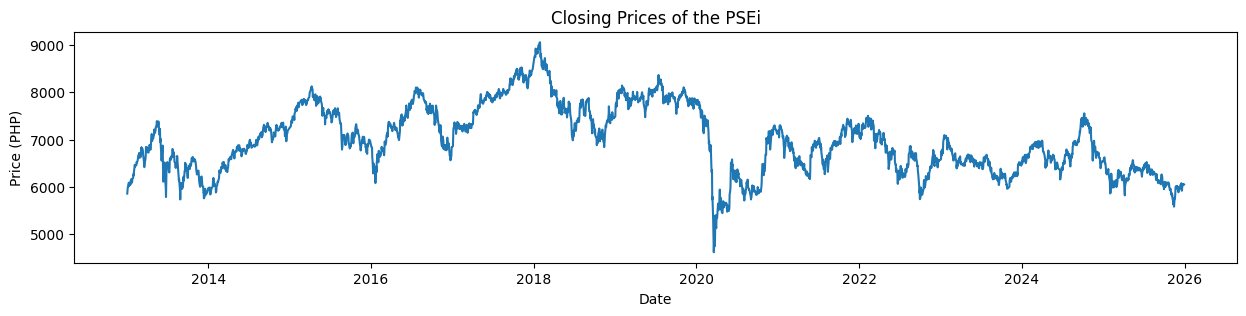

In [5]:
# plot the closing prices of the PSEi
plt.figure(figsize=(15, 3))
plt.plot(pse_data)
plt.xlabel('Date')
plt.ylabel('Price (PHP)')
plt.title('Closing Prices of the PSEi')
plt.show()

The data does not look stationary.

ADF Result: Stationary
KPSS Result: Stationary


C:\Users\Donna\AppData\Local\Temp\ipykernel_56400\325655696.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(log_returns)[1]


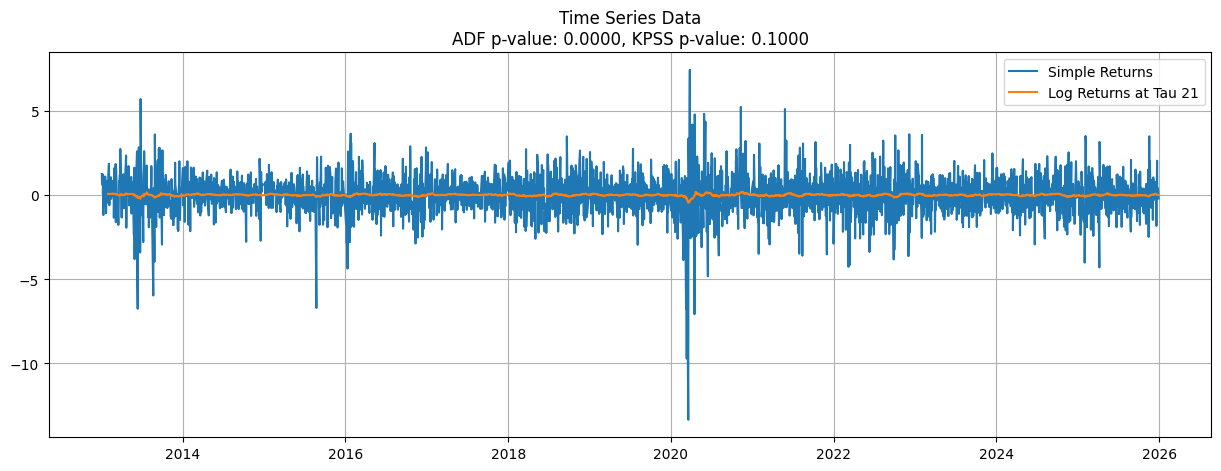

In [6]:
# get log returns
tau_val = 21
log_returns = np.log(pse_data['PSEI.PS']).diff(tau_val).dropna()
simple_returns = 100 * pse_data.pct_change().dropna()
pse_data_volatility = log_returns.rolling(window=2).std()

# checking for stationarity
p_value = 0.05
adf_res = adfuller(log_returns)[1]
kpss_res = kpss(log_returns)[1]

print("ADF Result:", "Stationary" if adf_res < p_value else "Not Stationary")
print("KPSS Result:", "Stationary" if kpss_res > p_value else "Not Stationary")

# plotting
plt.figure(figsize=(15, 5))
plt.plot(simple_returns, label='Simple Returns')
plt.plot(log_returns, label=f'Log Returns at Tau {tau_val}')
plt.title(f"Time Series Data\nADF p-value: {adf_res:.4f}, KPSS p-value: {kpss_res:.4f}")
plt.grid(True)
plt.legend()
plt.show()

## Train, val, test

In [7]:
# train test split with lookback
def train_test_split(data: pd.Series, lookback: int = 12, test_size: int = 12) -> Tuple[pd.Series, pd.Series]:
    """Create a train-test split on your pd.Series data.

    Parameters:
    -----------
    data (pd.Series): The univariate time series provided
    lookback (int): The lookback periods to consider
    test_size (int): The length of the test set

    Returns:
    --------
    Tuple (pd.Series): The (train, test) pandas series generated
    """
    
    split = data.shape[0] - test_size
    return (
        data.iloc[:split],
        data.iloc[split - lookback: ]
    )

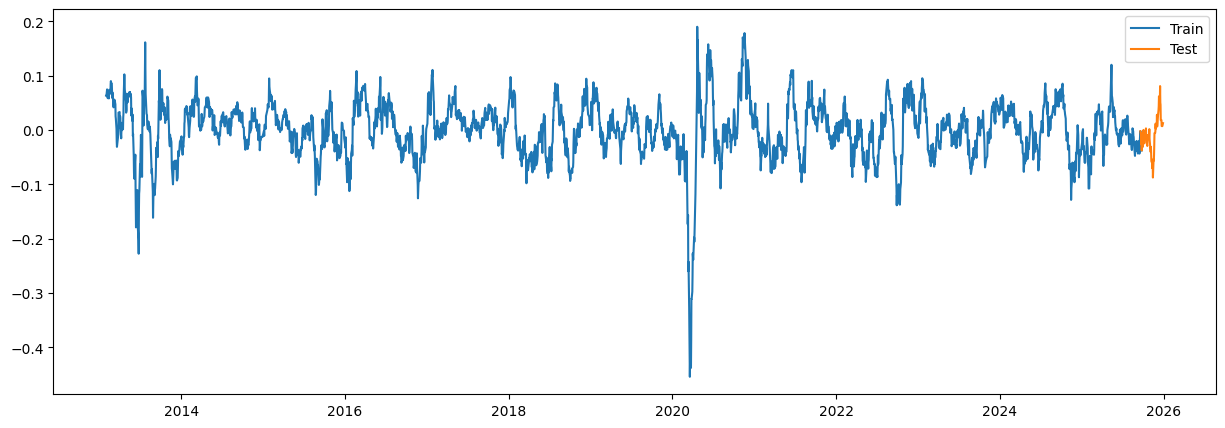

In [8]:
# determine number of points
test_percent = 0.2
test_size = int(np.floor(len(log_returns) * test_percent))
test_size = 63

# splitting
train, test = train_test_split(
    log_returns, 5, test_size
)

# plotting
plt.figure(figsize=(15, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend()
plt.show()

## Defining p, d, q

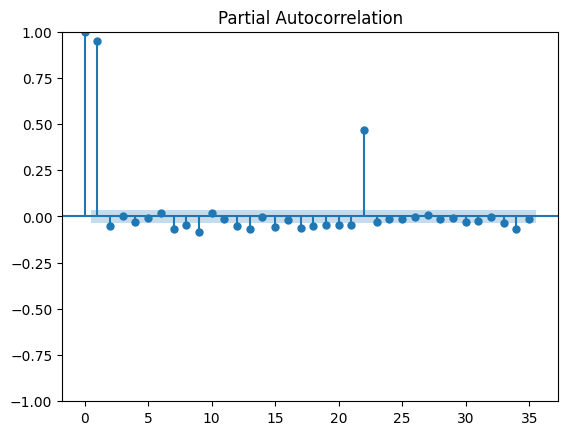

In [9]:
pacf_res = plot_pacf(train)

Based on the PACF plot, the best value for p is 1.

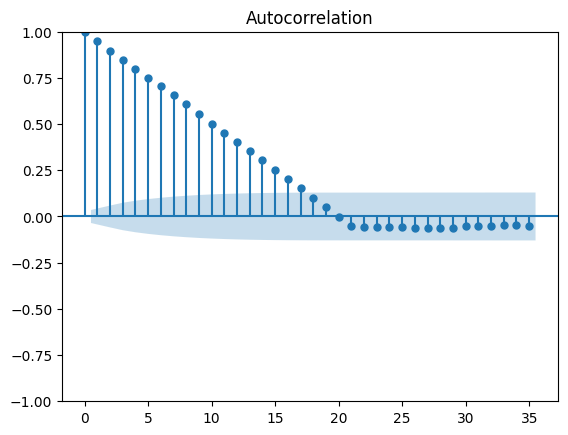

In [10]:
acf_res = plot_acf(train)

Based on the ACF plot, the best value for p is 17.

## GARCH Model

Since I couldn't find good lags for the ACF and PACF, then I opted to use GARCH(1,1).

In [11]:
# creating the model
model = arch_model(train, p=1, q=17)
model_fit = model.fit()

Iteration:      1,   Func. Count:     22,   Neg. LLF: 3.5801227174489862e+19
Iteration:      2,   Func. Count:     51,   Neg. LLF: 1.9275467918275264e+16
Iteration:      3,   Func. Count:     78,   Neg. LLF: 31405133.39806713
Iteration:      4,   Func. Count:    108,   Neg. LLF: 134806138.34450537
Iteration:      5,   Func. Count:    138,   Neg. LLF: 413687473981618.3
Iteration:      6,   Func. Count:    164,   Neg. LLF: 7.063470329965597e+16
Iteration:      7,   Func. Count:    191,   Neg. LLF: 17492479.0871063
Iteration:      8,   Func. Count:    220,   Neg. LLF: 3127739102543081.5
Iteration:      9,   Func. Count:    247,   Neg. LLF: 6678897.948367061
Iteration:     10,   Func. Count:    275,   Neg. LLF: -5493.8060518679795
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5493.806094650714
            Iterations: 14
            Function evaluations: 275
            Gradient evaluations: 10


C:\Users\Donna\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002755. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [12]:
# getting predictions
predictions = model_fit.forecast(horizon = test_size)
preds = predictions.variance.values[-1, :]
preds = pd.Series(preds, index=log_returns[-test_size:].index)

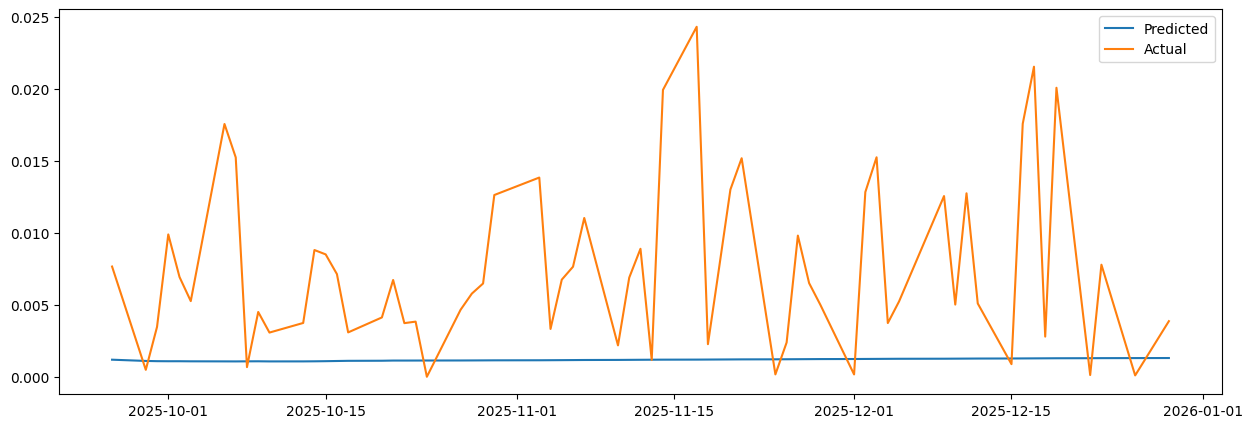

In [13]:
# plotting
plt.figure(figsize=(15, 5))
plt.plot(preds, label='Predicted')
plt.plot(pse_data_volatility[-test_size:], label='Actual')
plt.legend()
plt.show()

## Gidea and Katz

### Embed to 50 dimensions

In [14]:
def create_xy(series: pd.Series, lookback: int = 12, horizon: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    """Create the X and y arrays from a pd.Series object. The `lookback`
    determines the number of features we would include in X. While the
    `horizon` paramter informs us how many points we'll need to forecast.

    Paramters:
    ----------
    series (pd.Series): the (n, 1) time series to be sliced into X and Y
    lookback (int): the lookback window to consider (default=12)
    horizon (int): the number of points to forecast for each row in X (default=1)

    Returns:
    -------
    (X, y) (Tuple): a tuple of ndarrays
    """
    x = []
    y = []
    
    series_size = series.shape[0]
    for i in range(series_size):
        
        # break loop if series is less than the required time horizon
        if series.iloc[(i + lookback): (i + lookback + horizon)].shape[0] < horizon:
            break
        x.append(
            series.iloc[i: (i + lookback)]
        )
        y.append(
            series.iloc[(i + lookback): (i + lookback + horizon)]
        )
    x = np.dstack(x)
    y = np.dstack(y)

    # Reshape x to (samples, features, lookback)
    x = np.swapaxes(x, 0, 2)
    # Then flatten (samples, features * lookback)
    x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

    # Reshape y tp (samples, horizon)
    y = np.swapaxes(y, 0, 2)
    y = y[:, :, 0]


    
    return x, np.array(y).flatten()

In [15]:
train, test = create_xy(log_returns, 50, 1)
print(train.shape)
print(test.shape)

(3094, 50)
(3094,)


In [16]:
train

array([[ 0.06310066,  0.06279227,  0.07491435, ..., -0.00029707,
         0.01130661,  0.00753812],
       [ 0.06279227,  0.07491435,  0.06803526, ...,  0.01130661,
         0.00753812,  0.00144071],
       [ 0.07491435,  0.06803526,  0.06130809, ...,  0.00753812,
         0.00144071,  0.02296891],
       ...,
       [-0.01464925, -0.00935413,  0.00309718, ...,  0.04663494,
         0.0182645 ,  0.01845175],
       [-0.00935413,  0.00309718, -0.00892611, ...,  0.0182645 ,
         0.01845175,  0.00743921],
       [ 0.00309718, -0.00892611, -0.01901668, ...,  0.01845175,
         0.00743921,  0.00728876]], shape=(3094, 50))

### L1 and L2 Norms

As far as I know, we cannot get a persistence diagram from just one stock because it wouldn't work for the first step, Rips filtration. 
Hence, I will just get the L1 and L2 norm for every window with numpy.

In [20]:
print(train.shape)
print(log_returns[:len(train)].shape)

(3094, 50)
(3094,)


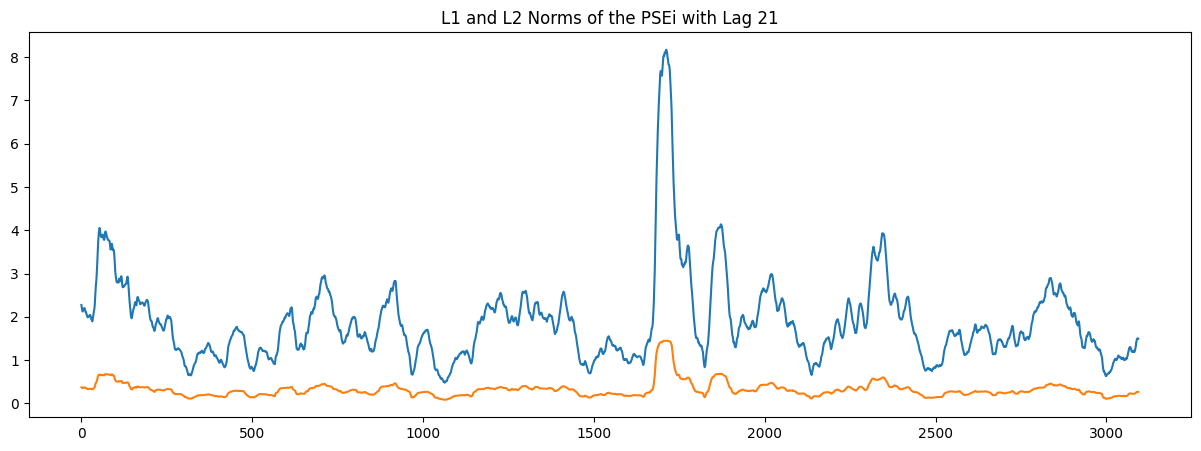

In [17]:
# get the norms
l1_norms = []
l2_norms = []
dates = log_returns[:len(train)].index
for i in range(len(train)):
    l1 = np.linalg.norm(train[i], ord=1)
    l2 = np.linalg.norm(train[i], ord=2)
    l1_norms.append(l1)
    l2_norms.append(l2)

# plot the landscapes
plt.figure(figsize=(15, 5))
plt.plot(l1_norms, label='L1 Norms')
plt.plot(l2_norms, label='L2 Norms')
plt.title(f'L1 and L2 Norms of the PSEi with Lag {tau_val}')
plt.show()

## Appendix

This section contains code that was created but not used and other personal notes that I want to keep for myself.

In [18]:
def get_norms(data):
    # get the persistence landscape
    rips = Rips(maxdim=1)
    dgms_pd = rips.fit_transform(data)
    pl = PersLandscapeApprox(dgms=dgms_pd, hom_deg=1)
    
    # get the L1 and L2 norms
    l1_norm = pl.pl_norm(1)
    l2_norm = pl.pl_norm(2)
    return l1_norm, l2_norm

### Personal Notes

1. Increasing the lag also allows for the ACF and PACF plots to pick up more signal.